# Embarassingly fast random subset sampling
Imagine we have an array. And a very large one. And we want to get large number of consecutive random samples from it, ideally such that the number of repeating elements will be as least as possible. The samples are generally much 

The naive approache would be to use `numpy.random.choice` every time we want to get a sample, but for really large arrays consisting of millions of elements this method:
* Turns out to be really slow
* Provides large number of collisions (duplicate draws form the array)

The code below provides optimized solution for this kind of problem, giving speedups in the order of 100000 when compared to naive solution.

A companion code for my Medium post.

## Algorithm

`numpy.random.choice` shuffles array each time we call it. Since in most cases with large arrays the sample size is much lower than the array size we can optimize by shufflig it only when strictly necessary. This will also reduce the number of collisions for arrays with non-repeating elements.

In [314]:
import numpy as np
from collections import Counter
from tqdm import tqdm

def get_sample(arr, n_iter=None, sample_size=10, 
               fast=True):
    """Get random sample from arr.
    
    Parameters
    ----------
    arr: np.array
        array to sample from.
    n_iter: int
        current iteration number.
    sample_size: int
        sample size
    fast: bool
        use sampling optimized for fast consecutive samples 
        from the same array.
    
    Returns
    -------
    sample: np.array
        sample from arr of length n_iter.
    """
    if fast:
        # find the index we last sampled from
        start_idx = (n_iter * sample_size) % n
        if start_idx + sample_size >= n:
            # shuffle array if we have reached the end and repeat again
            np.random.shuffle(arr)
            
        return arr[start_idx:start_idx+sample_size] 
    else:
        return np.random.choice(arr, sample_size, replace=False)
    
def collect_samples(arr,
                    sample_size,
                    n_samples,
                    fast=False):
    """
    Collect several samples from arr.
    
    Parameters
    ----------
    arr: np.array
        array to sample from.
    sample_size: int
        sample size.
    n_samples: int
        number of samples to take.
    fast: bool
        use sampling optimized for fast consecutive samples 
        from the same array.
    
    Returns
    -------
    samples: np.ndarray
        sample matrix of shape (n_samples, sample_size)
    """
    samples = np.zeros((n_samples + 1, sample_size), np.int32)
    
    for sample_n in range(0, n_samples):
        sample = get_sample(arr, 
                            n_iter=sample_n,
                            sample_size=sample_size,
                            fast=fast)
        samples[sample_n] = sample
        
    return samples

def collect_collisions(arr, sample_size, n_samples, 
                       fast=False):
    """Collect total number of collisions made for each sample of arr.
    
    Parameters
    ----------
    arr: np.array
        array to sample from.
    sample_size: int
        sample size.
    n_samples: int
        number of samples to take.
    fast: bool
        use sampling optimized for fast consecutive samples 
        from the same array.
    
    Returns
    -------
    collisions: np.array
        collision number for each sample taken
    """
    samples = collect_samples(arr, 
                              sample_size,
                              n_samples,
                              fast=fast).flatten()
    
    # count collisions for *all* numbers we have sampled
    counts = Counter(samples)
    collision_sum = sum([count for k, count in counts.items() if count > 1])
    
    return collision_sum


In [336]:
n = 10000

choice_num = []
fast_num = []
for i in tqdm(range(0, 500), desc="Collecting sample statistics"):
    arr = np.array([i for i in range(n)])
    # copy arrays so all experiments will be isolated in terms of array shuffling 
    arr_fast = arr.copy()
    collisions = collect_collisions(arr, 1000, 10, fast=False)
    collisions_fast = collect_collisions(arr_fast, 1000, 10, fast=True)
    choice_num.append(collisions)
    fast_num.append(collisions_fast)

Let's see if collision numbers differ significantly by performing the t-test

In [337]:
from scipy.stats import ttest_rel 

# We must do depentent t-test since all statistics were collected from the 
# same array
ch_fast_test = ttest_rel(choice_num, fast_num)
print(f"choice sampling vs fast sampling significant: {ch_fast_test.pvalue < 0.05}, p = {ch_fast_test.pvalue}")

choice sampling vs fast sampling significant: True, p = 0.0


In [338]:
np.mean(choice_num), np.mean(fast_num)

(7125.71, 2800.9960000000001)

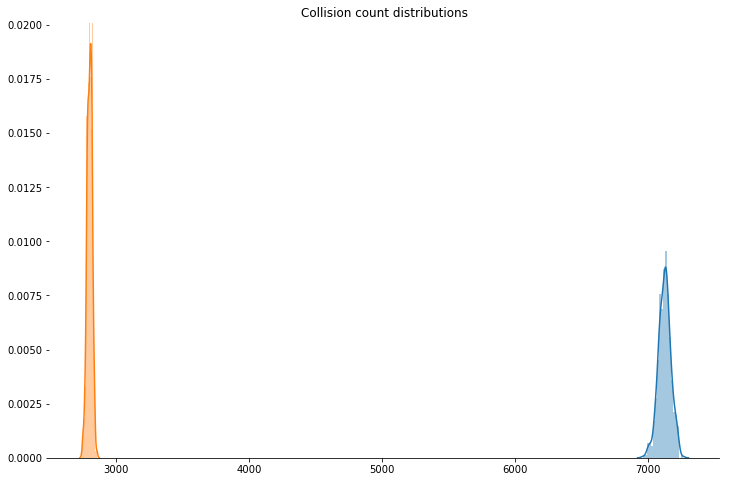

In [335]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,8),sharey=True)
sns.despine(left=True)
sns.distplot(choice_num, ax=ax)
sns.distplot(fast_num, ax=ax)
ax.set_title("Collision count distributions")

## Benchmarks
Let's do some benchmarks on a large array

In [326]:
n = 3000000
arr = np.array([i for i in range(n)]).astype(np.int64)

In [327]:
%timeit collect_samples(arr, 1000, 10, fast=False)

1.39 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [328]:
%timeit collect_samples(arr, 1000, 10, fast=True)

21.1 µs ± 979 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Great speedup, from seconds to microseconds! But can we do better? Using Cython and compiling everything to native code could help, so let's try it.

In [198]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [329]:
%%cython 
import numpy as np
cimport numpy as np
cimport cython # so we can use cython decorators
from cpython cimport bool # type annotation for boolean

# disable index bounds checking and negative indexing for speedups
@cython.wraparound(False)
@cython.boundscheck(False)
cdef cython_get_sample(np.ndarray arr, arr_len, n_iter, int sample_size, 
               bool fast):
    cdef int start_idx
    if fast:
        start_idx = (n_iter * sample_size) % arr_len
        if start_idx + sample_size >= arr_len:
            np.random.shuffle(arr)
            
        return arr[start_idx:start_idx+sample_size] 
    else:
        return np.random.choice(arr, sample_size, replace=False)

@cython.wraparound(False)
@cython.boundscheck(False)
def cython_collect_samples(np.ndarray arr,
                    int sample_size,
                    int n_samples,
                    bool fast=False):
    
    cdef np.ndarray samples
    cdef int arr_len
    cdef int sample_len
    cdef np.ndarray sample
    samples = np.zeros((n_samples + 1, sample_size), np.int64)
    arr_len = len(arr)
    
    for sample_n in range(0, n_samples):
        sample = cython_get_sample(arr, arr_len, sample_n,
                            sample_size,
                            fast)
        samples[sample_n] = sample
        
    return samples

In [330]:
%timeit cython_collect_samples(arr, 1000, 10, fast=True)

13.2 µs ± 213 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Almost 2 times faster compared to plain python code. Have fun!